<a href="https://colab.research.google.com/github/nikolina-p/Loan-calculator/blob/master/Streaming_Datasets_LLM_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

In [ ]:
%%capture
!pip install tiktoken

In [ ]:
%%capture
!pip install -U datasets

## **GPT MODEL**
1. Multi-head self-attention mechanism
2. Feed-forward layer
3. Transformer block (1 + 2)

### **Multi-head self-attention mechanism**

In [ ]:
import torch
from torch import nn

class MultiHeadAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout) # preventing overfitting - only used in training

        # non-trainable parameters part of the model's state, move and save/load with the model
        self.register_buffer("mask", torch.triu(
            torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape # b - batches

        queries = self.W_query(x) # b x d_in x d_in
        keys = self.W_key(x)
        values = self.W_value(x)

        # creating HEADs: step 1
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # creating HEADs: step 2
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        att_scores = queries @ keys.transpose(2,3) # dot product


        att_scores = att_scores.masked_fill(
            self.mask.bool()[:num_tokens, :num_tokens],
            -torch.inf
        )

        # scale and normalize
        att_weights = torch.softmax(
            att_scores / keys.shape[-1] ** 0.5,
            dim=-1
            )

        att_weights = self.dropout(att_weights)

        context_vec = att_weights @ values # # (b, num_tokens, num_heads, head_dim)

        # reverse shaping
        context_vec = context_vec.transpose(1, 2) # (b, num_heads, num_tokens, head_dim)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        context_vec = self.out_proj(context_vec)

        return context_vec

### **Feedforwar layer**
**MLP - Multilayer Perceptron**

In [ ]:
class LayerNorm(nn.Module):

    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5 # helps avoid division by 0
        self.scale = nn.Parameter(torch.ones(emb_dim)) # learnable
        self.shift = nn.Parameter(torch.zeros(emb_dim)) # learnable

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


In [ ]:
# activation function
class GELU(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
                ))


In [ ]:

class FeedForward(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            )

    def forward(self, x):
        return self.layers(x)

### **Transformer Block**

In [ ]:
class TransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()

        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"], # dimension of input embeddings
            d_out=cfg["emb_dim"], # dimension of output embeddings
            context_length=cfg["context_length"], # number of tokens in one sequence
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"], # rate used for dropout
            qkv_bias=cfg["qkv_bias"]) # True/False - use bias in query, key and value weights matrices or not

        self.ff = FeedForward(cfg)

        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"]) # dropout layer

    def forward(self, x):
        # Multi-Head Self-Attention Layer
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # Feed-Forward Layer
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

### **GPT MODEL**

In [ ]:
from huggingface_hub import PyTorchModelHubMixin

class GPTModel(nn.Module, PyTorchModelHubMixin):

    def __init__(self, cfg):
        super().__init__()
        # self.cfg = cfg

        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
            )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
            )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        x = self.trf_blocks(x)

        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

## **GPT configuration**

In [ ]:
# the model coded in this notebook has 163M parameters, 'cos it is not using weight tying (using tok.emb for out_head) like original GPT2
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 512, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}

## **text generating functions**

In [ ]:
# text generating function
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        probabilities = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probabilities, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [ ]:
def text_to_token_ids(text, tokenizer, device):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # adds the batch dimension
    return encoded_tensor.to(device)

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # removes the batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
def talk_to_me(model, text, max_new_tokens, context_size, tokenizer, device):
    idx = text_to_token_ids(text, tokenizer, device)
    response_idx = generate_text_simple(model, idx, max_new_tokens, context_size)
    return token_ids_to_text(response_idx, tokenizer)

## **StreamingDataset**

In [ ]:
from torch.utils.data import IterableDataset, DataLoader
import re

class BookStreamProcessor(IterableDataset):
    """An iterator class that keeps track of number of pulled books,
     eliminates duplicate books and applies basic text cleaning."""

    def __init__(self, raw_stream, start=0):
        self.raw_stream = iter(islice(raw_stream, start, None)) # skip the books previously used for training
        self.books_seen = set()
        self.book_counter = start # tracks num of books pulled from the raw stream; used to resume training without repeating training data

    def __iter__(self):
        while True:
            try:
                book = next(self.raw_stream)
                self.book_counter += 1
                if book["id"] not in self.books_seen:
                    self.books_seen.add(book["id"])
                    book["text"] = self.preprocess(book["text"])
                    yield book
            except StopIteration:
                print("BookStreamProcessor: No more books")
                break

    def preprocess(self, text):
        text = self.strip_gutenberg_header_footer(text)
        text = self.clean_newlines(text)
        return text

    def strip_gutenberg_header_footer(self, text):
        # remove header before ***START ...*** or *** START ... ***
        start_match = re.search(r"\*{3}\s*START[^*]*\*{3}", text, re.IGNORECASE)
        if start_match:
            text = text[start_match.end():]

        # remove footer after ***END ...*** or *** END ...***
        end_match = re.search(r"\*{3}\s*END[^*]*\*{3}", text, re.IGNORECASE)
        if end_match:
            text = text[:end_match.start()]
        return text.strip()

    def clean_newlines(self, text):
        # Replace 3 or more newlines with 2 newlines (paragraph break)
        return re.sub(r'\n{3,}', '\n\n', text)


In [ ]:
import random, torch, gc

class StreamingDataset(IterableDataset):
    """An iterable dataset that tokenizes book texts from a stream,
    generates input-target sequence pairs, and shuffles sequences at the book level."""

    def __init__(self, dataset, tokenizer, context_size):
        super().__init__()
        self.datasource = iter(BookStreamProcessor(dataset))
        self.tokenizer = tokenizer
        self.context_size = context_size

    def __iter__(self):
        while True:
            try:
                book = next(self.datasource)
                book_token_ids = self.tokenizer.encode(book["text"],
                                                       allowed_special={"<|endoftext|>"})
                if len(book_token_ids) < self.context_size:
                    print(f"Book {book['id']} too short - not enough tokens.")
                    continue
                # loop trough shuffled start_indices of input_chunk(s) and create pairs
                for i in self.shuffle_indices(len(book_token_ids)):
                    input_chunk = book_token_ids[i:i + self.context_size]
                    target_chunk = book_token_ids[i + 1:i + self.context_size + 1]
                    yield book["id"], torch.tensor(input_chunk), torch.tensor(target_chunk)
            except StopIteration:
                print("StreamingDataset: no more data")
                break

    def shuffle_indices(self, num_tokens_book):
        start_indices = list(range(0, num_tokens_book - self.context_size, self.context_size))
        random.seed(123)
        random.shuffle(start_indices)
        return start_indices

**Calculate loss STREAMING**

In [ ]:
# calculates the loss per one batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    model = model.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


**Save checkpoint and training data**

In [ ]:
# save the model and optimizer state
def save_checkpoint(model, optimizer, scaler, num):
    print(f"Saving checkpoint...{num}")
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scaler_state_dict": scaler.state_dict()
        },
        f"checkpoint_cycle_{num}.pth"
        )

#load the model and optimizer
def load_checkpoint(file_name, model_config):
    checkpoint = torch.load(file_name, map_location=device)
    model = GPTModel(model_config)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return model, optimizer

In [ ]:
import json
from datetime import datetime
import matplotlib.pyplot as plt

# save training results in json file
def save_training_info(train_losses, valid_losses, track_tokens_seen_t,
                       track_tokens_seen_v, books_seen, times):
    data = {
        "train_losses": train_losses,
        "valid_losses": valid_losses,
        "track_tokens_seen_t": track_tokens_seen_t,
        "track_tokens_seen_v": track_tokens_seen_v,
        "books_processed": list(books_seen),
        "time per cycle": times
    }

    date_str = datetime.now().strftime("%Y-%m-%d")

    with open(f"results_{date_str}_books_{len(books_seen)}.json", "w", encoding="UTF-8") as f:
        json.dump(data, f, indent=4)


def plot_loss_convergence(train_losses, val_losses):
    cycles = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(cycles, train_losses, label='Training Loss', marker='o')
    plt.plot(cycles, val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Cycle')
    plt.ylabel('Loss')
    plt.title('Loss Convergence')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

##### **Train model - A100 - accumulate gradients**

In [ ]:
import time

def train_model_streaming_A100(model, data_loader, optimizer, scaler, mix_prec,
                               device, num_epoch, training_batches, val_ratio):
    # track losses per cycle and tokens seen
    train_losses, valid_losses = [], []
    books_seen = set()
    times = [] # execution time per validation cycle
    tokens_seen_train, tokens_seen_valid = 0, 0

    # Main training loop
    try:
        for epoch in range(num_epoch):
            loss_train, train_batch_count = 0, 0 # accumulated loss in a cycle; number of batches in a cycle
            loss_valid, valid_batch_count = 0, 0
            tokens_seen_train, tokens_seen_valid = 0, 0
            training_mode = True # start in training mode by default
            model.train()
            cyc_start_time = time.time()
            ACCUMULATE_GRAD_STEPS = 0

            for book_id_batch, input_batch, target_batch in data_loader:
                books_seen.update((book_id_batch[0], book_id_batch[-1]))
                # train
                if training_mode:
                    ACCUMULATE_GRAD_STEPS += 1
                    # print results of the previous validation cycle, if any, and SAVE A CHECKPOINT
                    if loss_valid != 0:
                        times.append(time.time() - cyc_start_time)
                        print(f"\nVALIDATION loss {(loss_valid/valid_batch_count):.3f}\nTotal tokens seen in validation: {tokens_seen_valid}")
                        print(f"Cycle time: {times[-1]}\n")
                        # save metrics
                        valid_losses.append((loss_valid / valid_batch_count).item())
                        # save a checkpoint
                        save_checkpoint(model, optimizer, scaler, len(books_seen))
                        # reset time and loss tracking variables for a new cycle
                        loss_valid = 0
                        valid_batch_count = 0
                        cyc_start_time = time.time()
                        # switch to train
                        model.train()

                    with torch.autocast(device_type=device.type, dtype=torch.bfloat16, enabled=mix_prec):
                        loss = calc_loss_batch(input_batch, target_batch, model, device)

                    scaler.scale(loss).backward() # Calculate loss gradients; scale them to prevent underflowing when mixed precision
                    if ACCUMULATE_GRAD_STEPS == 4:
                        scaler.step(optimizer) # Update model weights
                        scaler.update()
                        optimizer.zero_grad(set_to_none=True)
                        ACCUMULATE_GRAD_STEPS = 0

                    tokens_seen_train += input_batch.numel()
                    loss_train += loss
                    train_batch_count += 1

                    if train_batch_count % training_batches == 0:
                        training_mode = False

                # Validate
                else:
                    # Print results of the previous training cycle
                    if loss_train != 0:
                        print(f"""\nTRAINING loss average: {(loss_train/train_batch_count):.3f}
                              Total tokens seen in training: {tokens_seen_train}\n""")
                        train_losses.append((loss_train / train_batch_count).item())
                        loss_train = 0
                        train_batch_count = 0
                        # Switch to evaluation mode
                        model.eval()

                    # Validate
                    with torch.no_grad():
                        loss = calc_loss_batch(input_batch, target_batch, model, device)
                        loss_valid += loss
                        valid_batch_count += 1
                        tokens_seen_valid += input_batch.numel()

                        if valid_batch_count % (training_batches * val_ratio) == 0:
                            training_mode = True

                # Handle remaining accumulated gradients at the end of an epoch if any
                if ACCUMULATE_GRAD_STEPS != 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                    ACCUMULATE_GRAD_STEPS = 0


    except KeyboardInterrupt:
        print("Saving model after KeyboardInterrupt")

    save_checkpoint(model, optimizer, scaler, len(books_seen))
    save_training_info(train_losses, valid_losses, tokens_seen_train,
                           tokens_seen_valid, books_seen, times)
    print(f"TOTAL TOKENS: {tokens_seen_train + tokens_seen_valid}")
    print(f"LOSSES: {train_losses[-1]}/{valid_losses[-1]}")
    plot_loss_convergence(train_losses, valid_losses)

    return train_losses, valid_losses, tokens_seen_train, tokens_seen_valid

#### **Train function - A100 - mixed precision**

In [ ]:
def train_model_streaming_mix_prec(model, data_loader, optimizer,scaler, mix_prec,
                                   device, num_epoch, training_batches, val_ratio):
    # track losses per cycle and tokens seen
    train_losses, valid_losses = [], []
    books_seen = set()
    times = [] # execution time per validation cycle
    tokens_seen_train, tokens_seen_valid = 0, 0

    # Main training loop
    try:
        for epoch in range(num_epoch):
            loss_train, train_batch_count = 0, 0 # accumulated loss in a cycle; number of batches in a cycle
            loss_valid, valid_batch_count = 0, 0

            training_mode = True # start in training mode by default
            model.train()

            cyc_start_time = time.time()

            for book_id_batch, input_batch, target_batch in data_loader:
                books_seen.update((book_id_batch[0], book_id_batch[-1]))
                # train
                if training_mode:
                    # print results of the previous validation cycle, if any, SAVE A CHECKPOINT
                    if loss_valid != 0:
                        times.append(time.time() - cyc_start_time)
                        print(f"\nVALIDATION loss {(loss_valid/valid_batch_count):.3f}")
                        print(f"Total tokens seen in validation: {tokens_seen_valid}\n")
                        print(f"Cycle time: {times[-1]}\n")
                        # save metrics
                        valid_losses.append((loss_valid / valid_batch_count).item())
                        # save the checkpoint
                        save_checkpoint(model, optimizer, scaler, len(books_seen))
                        # reset tracking variables for a new cycle
                        loss_valid = 0
                        valid_batch_count = 0
                        cyc_start_time = time.time()

                        # Switch to train
                        model.train()


                    optimizer.zero_grad(set_to_none=True)
                    with torch.autocast(device_type=device.type, dtype=torch.bfloat16, enabled=mix_prec):
                        loss = calc_loss_batch(input_batch, target_batch, model, device)
                    scaler.scale(loss).backward()
                    scaler.step(optimizer) # update model weights
                    scaler.update()

                    tokens_seen_train += input_batch.numel()
                    loss_train += loss
                    train_batch_count += 1

                    if train_batch_count % training_batches == 0:
                        training_mode = False

                # validate
                else:
                    # print results of the previous training cycle
                    if loss_train != 0:
                        print(f"\nTRAINING loss average: {(loss_train/train_batch_count):.3f}")
                        print(f"Total tokens seen in training: {tokens_seen_train}\n")
                        train_losses.append((loss_train / train_batch_count).item())
                        loss_train = 0
                        train_batch_count = 0
                        # switch to evaluation mode
                        model.eval()

                    # validate
                    with torch.no_grad():
                        loss = calc_loss_batch(input_batch, target_batch, model, device)
                        loss_valid += loss
                        valid_batch_count += 1
                        tokens_seen_valid += input_batch.numel()

                        if valid_batch_count % (training_batches * val_ratio) == 0:
                            training_mode = True

    except KeyboardInterrupt:
        print("Saving model after KeyboardInterrupt...")

    save_checkpoint(model, optimizer, scaler, len(books_seen))
    save_training_info(train_losses, valid_losses, tokens_seen_train,
                           tokens_seen_valid, books_seen, times)
    print(f"TOTAL TOKENS: {tokens_seen_train + tokens_seen_valid}")
    print(f"LOSSES: {train_losses[-1]}/{valid_losses[-1]}")
    plot_loss_convergence(train_losses, valid_losses)

    return train_losses, valid_losses, tokens_seen_train, tokens_seen_valid

##### **Train model STREAMING - no optimization**

In [ ]:
def train_model_streaming_batches(model, data_loader, optimizer, device, num_epoch, batch_size, training_batches, val_ratio):
    # track losses per cycle and tokens seen
    train_losses, valid_losses, track_tokens_seen_t, track_tokens_seen_v = [], [], [], []
    books_seen = set()

    # Main training loop
    try:
        for epoch in range(num_epoch):
            loss_train, train_batch_count = 0, 0 # accumulated loss in a cycle; number of batches in a cycle
            loss_valid, valid_batch_count = 0, 0
            tokens_seen_train, tokens_seen_valid = 0, 0

            training_mode = True # start in training mode by default
            model.train()

            for book_id_batch, input_batch, target_batch in data_loader:
                books_seen.update((book_id_batch[0], book_id_batch[-1]))
                # train
                if training_mode:
                    # print results of the previous validation cycle, if any, and SAVE A CHECKPOINT
                    if loss_valid != 0:
                        print(f"\nVALIDATION loss {(loss_valid/valid_batch_count):.3f}\t\tTotal tokens seen in validation: {tokens_seen_valid}\n")
                        valid_losses.append((loss_valid / valid_batch_count).item())
                        track_tokens_seen_v.append(tokens_seen_valid)
                        save_checkpoint(model, optimizer, len(books_seen))
                        save_training_info(train_losses, valid_losses, track_tokens_seen_t,
                                           track_tokens_seen_v, books_seen)
                        loss_valid = 0
                        valid_batch_count = 0

                    # train
                    model.train()
                    optimizer.zero_grad(set_to_none=True)
                    loss = calc_loss_batch(input_batch, target_batch, model, device)
                    loss.backward() # Calculate loss gradients
                    optimizer.step() # Update model weights using loss gradients
                    tokens_seen_train += input_batch.numel()
                    loss_train += loss
                    train_batch_count += 1

                    if train_batch_count % training_batches == 0:
                        training_mode = False

                # validate
                else:
                    # print results of the previous training cycle
                    if loss_train != 0:
                        print(f"\nTRAINING loss average: {(loss_train/train_batch_count):.3f}\t\tTotal tokens seen in training: {tokens_seen_train}\n")
                        train_losses.append((loss_train / train_batch_count).item())
                        track_tokens_seen_t.append(tokens_seen_train)
                        loss_train = 0
                        train_batch_count = 0

                    # validate
                    with torch.no_grad():
                        model.eval()
                        loss = calc_loss_batch(input_batch, target_batch, model, device)
                        loss_valid += loss
                        valid_batch_count += 1
                        tokens_seen_valid += input_batch.numel()

                        if valid_batch_count % (training_batches * val_ratio) == 0:
                            training_mode = True

    except KeyboardInterrupt:
        print("Saving model after KeyboardInterrupt")
        save_checkpoint(model, optimizer, len(books_seen))
        save_training_info(train_losses, valid_losses, track_tokens_seen_t,
                           track_tokens_seen_v, books_seen)

    save_checkpoint(model, optimizer, len(books_seen))

    return train_losses, valid_losses, track_tokens_seen_t, track_tokens_seen_v

##### **Train model STREAMING - split per no of books**

In [ ]:
def train_model_streaming(model, data_loader, optimizer, device, tokenizer, num_epoch=1, num_books_train=5, num_books_valid=1):
    # Initialize lists to track losses and tokens seen
    train_losses, valid_losses, track_tokens_seen_t, track_tokens_seen_v = [], [], [], []

    # Main training loop
    for epoch in range(num_epoch):
        loss_train, train_batch_count = 0, 0 # accumulated loss in a cycle; number of batches in a cycle
        loss_valid, valid_batch_count = 0, 0
        tokens_seen_train, tokens_seen_valid = 0, 0

        books_seen = []
        cycle = num_books_train + num_books_valid

        training_mode = True # start in training mode by default
        model.train()

        for book_id_batch, input_batch, target_batch in data_loader:

            # determine if it is a book for training or validation
            book_id = book_id_batch[0]
            if not books_seen or books_seen[-1] != book_id: # if it is a first book or a new book
                books_seen.append(book_id)
                # determine is it train or val book
                index = (len(books_seen)-1) % cycle
                training_mode = True if index < num_books_train else False

            # train
            if training_mode:
                # print results of the previous validation cycle, if any, and SAVE A CHECKPOINT
                if loss_valid != 0:
                    print(f"\nVALIDATION loss {(loss_valid/valid_batch_count):.3f}\t\tTotal tokens seen in validation: {tokens_seen_valid}\n")
                    valid_losses.append((loss_valid / valid_batch_count).item())
                    track_tokens_seen_v.append(tokens_seen_valid)
                    save_checkpoint(model, optimizer, len(books_seen))
                    loss_valid = 0
                    valid_batch_count = 0

                # train
                model.train()
                optimizer.zero_grad()
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                loss.backward() # Calculate loss gradients
                optimizer.step() # Update model weights using loss gradients
                tokens_seen_train += input_batch.numel()
                loss_train += loss
                train_batch_count += 1
                loss_valid = 0
                valid_batch_count = 0

            # validate
            else:
                # print results of the previous training cycle
                if loss_train != 0:
                    print(f"\nTRAINING loss average: {(loss_train/train_batch_count):.3f}\t\tTotal tokens seen in training: {tokens_seen_train}\n")
                    train_losses.append((loss_train / train_batch_count).item())
                    track_tokens_seen_t.append(tokens_seen_train)
                    loss_train = 0
                    train_batch_count = 0

                # validate
                with torch.no_grad():
                    model.eval()
                    loss = calc_loss_batch(input_batch, target_batch, model, device)
                    loss_valid += loss
                    valid_batch_count += 1
                    tokens_seen_valid += input_batch.numel()

    save_checkpoint(model, optimizer, len(books_seen))

    return train_losses, valid_losses, track_tokens_seen_t, track_tokens_seen_v

#### ---

**Load the streaming dataset**

In [ ]:
from datasets import load_dataset
import tiktoken
from itertools import islice

ds_gutenberg = load_dataset("manu/project_gutenberg", split="en", streaming=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

**Log into my Huggingface account**

In [ ]:
%%capture
!pip install huggingface_hub

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
!huggingface-cli whoami

nikolina-p


**MAIN**


TRAINING loss average: 5.668
                              Total tokens seen in training: 22528000


VALIDATION loss 5.755
Total tokens seen in validation: 2252800
Cycle time: 289.3422212600708

Saving checkpoint...199

TRAINING loss average: 5.311
                              Total tokens seen in training: 45056000


VALIDATION loss 5.527
Total tokens seen in validation: 4505600
Cycle time: 217.07440662384033

Saving checkpoint...429

TRAINING loss average: 4.912
                              Total tokens seen in training: 67584000


VALIDATION loss 5.080
Total tokens seen in validation: 6758400
Cycle time: 217.12939167022705

Saving checkpoint...633
Saving model after KeyboardInterrupt
Saving checkpoint...642
TOTAL TOKENS: 75716608
LOSSES: 4.912260055541992/5.080458164215088


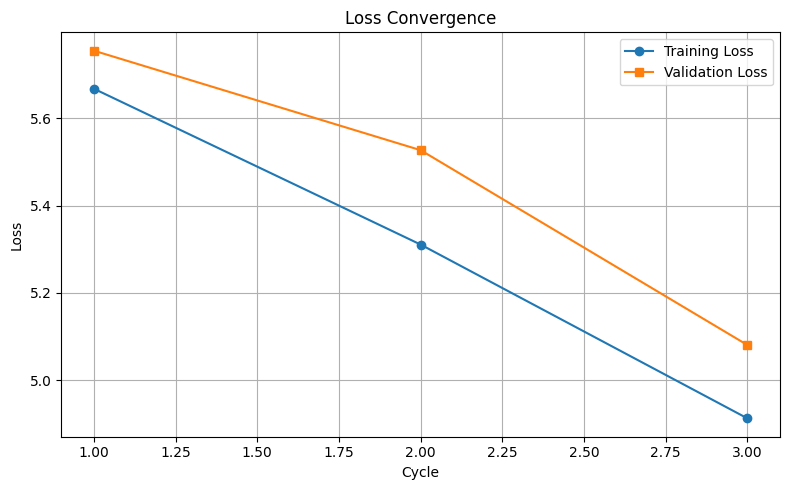

Training completed in 12.72 minutes.


In [ ]:
import pdb
import time
import itertools

start_time = time.time()

torch.manual_seed(123)
torch.set_float32_matmul_precision('high') # current GPU supports TensorFloat-32

model = GPTModel(GPT_CONFIG_124M)
model.compile()

# load model from the HUB
# model = GPTModel.from_pretrained("nikolina-p/GPT_from_scratc_5_books")
# print(f">>> Model from HF vocab size: {model.tok_emb.num_embeddings}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
mix_prec = True
scaler = torch.amp.GradScaler("cuda", enabled=mix_prec) # set True/False to use mixed precision

tokenizer = tiktoken.get_encoding("gpt2")
streaming_dataset = StreamingDataset(ds_gutenberg, tokenizer, context_size=GPT_CONFIG_124M['context_length'])

loader = DataLoader(streaming_dataset,
                    batch_size=44,
                    drop_last=True,
                    num_workers=2,
                    pin_memory=True
                   )

train_losses, valid_losses, tokens_train, tokens_valid = train_model_streaming_A100(model,
                                                                                        loader,
                                                                                        optimizer,
                                                                                        scaler,
                                                                                        mix_prec,
                                                                                        device,
                                                                                        num_epoch=1,
                                                                                        training_batches=1000,
                                                                                        val_ratio=0.1
                                                                                        )


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [ ]:
!pwd

/content


#### **Postprocessing**
- save training results into permanent file
- printing loses and number of processed tokens per cycle
- upload the model to Huggingface Hub

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

report_path = "/content/drive/MyDrive/train_log.txt"

with open(report_path, "a") as f:
    f.write("New training run:\n")
    f.write("Tokens seen: 4,000,000\n")
    f.write("Train loss: 5.32\n")
    f.write("Val loss: 5.01\n\n")

**Load a model from a checkpoint**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_ch91, optimizer_ch91 = load_checkpoint("checkpoint_cycle_91.pth", GPT_CONFIG_124M_test)

train_losses = [7.5] # dummy
valid_losses = [6.5] # dummy

**Push the model to the Huggingface Hub**
- prepare the model card
- save the PyTorch model with Hugingface save_pretrained() function. I used Huggingface PyTorchModelHubMixin class for this - my PyTorch model extends this class and so gets the functionalities like `from_pretrained` and `push_to_hub`.
- push the model and the card to the Hub

In [ ]:
import yaml
from huggingface_hub import ModelCard, ModelCardData

card_data = ModelCardData(language='en', license='mit', library_name='torch')

content = f"""\
---
{ card_data.to_yaml() }
---

This model is GPT model created from scratch with following configuration:\n
\t{yaml.dump(GPT_CONFIG_124M, sort_keys=False)}

Test dataset used for training and validation is one book from manu/project_gutenberg dataset, English split.
It is trained for 4.6 minutes in Google Colab on A100 GPU. Total tokens seen in training: 177900.
Total tokens seen in validation: 152700.

It acheives following results:
- Training loss: {train_losses[-1]:.3f}
- Validation loss: {valid_losses[-1]:.3f}
"""

card = ModelCard(content)
print(card)

---
language: en
library_name: torch
license: mit
---

This model is GPT model created from scratch with following configuration:

	vocab_size: 50257
context_length: 512
emb_dim: 768
n_heads: 12
n_layers: 12
drop_rate: 0.1
qkv_bias: false


Test dataset used for training and validation is one book from manu/project_gutenberg dataset, English split.
It is trained for 4.6 minutes in Google Colab on A100 GPU. Total tokens seen in training: 177900. 
Total tokens seen in validation: 152700

It acheives following results:
- Training loss: 5.964
- Validation loss: 6.939



In [ ]:
model.save_pretrained("GPT_from_scratc_workers_2")

In [ ]:
talk_to_me(model, "Hello there", 15, 256, tokenizer, device)

'Hello there.\n\n\n\n\n\n\n\n\n\n\n\n\n\n'

In [ ]:
model.push_to_hub(
    repo_id="nikolina-p/GPT_from_scratc_workers_2",
    commit_message="Uploaded model trained with 2 workers.",
    )


model.safetensors:   0%|          | 0.00/663M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/nikolina-p/GPT_from_scratc_5_books/commit/9cd8ce04d843ff13122e72adc1abf1262b8adf40', commit_message='Uploaded model - 5 books.', commit_description='', oid='9cd8ce04d843ff13122e72adc1abf1262b8adf40', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nikolina-p/GPT_from_scratc_5_books', endpoint='https://huggingface.co', repo_type='model', repo_id='nikolina-p/GPT_from_scratc_5_books'), pr_revision=None, pr_num=None)

In [ ]:
card.push_to_hub("nikolina-p/GPT_from_scratc_5_books")

CommitInfo(commit_url='https://huggingface.co/nikolina-p/GPT_from_scratc_5_books/commit/34509e355bc4e7ad69fa50c043674136c4898745', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='34509e355bc4e7ad69fa50c043674136c4898745', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nikolina-p/GPT_from_scratc_5_books', endpoint='https://huggingface.co', repo_type='model', repo_id='nikolina-p/GPT_from_scratc_5_books'), pr_revision=None, pr_num=None)

## **TESTING...**

In [ ]:
GPT_CONFIG_124M_test = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 50, # Context length
    "emb_dim": 768, # Embedding dimension
    "n_heads": 12, # Number of attention heads
    "n_layers": 12, # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False # Query-Key-Value bias
}


In [ ]:
# saving a book for testing
import os

book = next(iter(ds_gutenberg))

with open("book.txt", "w", encoding="utf-8") as f:
    f.write(book["text"])

In [ ]:
# json line file, one line - one book
import json

test_dataset = []

with open("book.txt", "r", encoding="utf-8") as f:
    text = f.read()
    for i in range(100):
        start = 4000 + i*1000
        end = 5000 + i*1000
        chunk = text[start:end]
        if chunk.strip():  # skip empty lines
            test_dataset.append({"id": i, "text": chunk})

with open("test_dataset.jsonl", "w", encoding="utf-8") as f:
    for example in test_dataset:
        f.write(json.dumps(example, ensure_ascii=False) + "\n")

In [ ]:
with open("test_dataset.jsonl", "r", encoding="utf-8") as f:
    x = f.readline()
    print(x)
    data = json.loads(x)
    print(len(data["text"].split()))


{"id": 0, "text": "provides the biographer with\nthe scantiest materials is Addison. In his _Journal to Stella_, his social\nverses, and his letters to his friends, we have a vivid picture of those\nrelations with women and that protracted suffering which invest with such\ntragic interest the history of Swift. Pope, by the publication of his own\ncorrespondence, has enabled us, in a way that he never intended, to\nunderstand the strange moral twist which distorted a nature by no means\ndevoid of noble instincts. Johnson was fortunate in the companionship of\nperhaps the best biographer who ever lived. But of the real life and\ncharacter of Addison scarcely any contemporary record remains. The formal\nnarrative prefixed to his works by Tickell is, by that writer's own\nadmission, little more than a bibliography. Steele, who might have told us\nmore than any man about his boyhood and his manner of life in London, had\nbecome estranged from his old friend before his death. No writer has\n

In [ ]:
with open("book.txt", "r", encoding="utf-8") as f:
    text = f.read()
    print(len(text))

358423


In [ ]:
# load test dataset
from datasets import load_dataset
import tiktoken

test_gutenberg = load_dataset("json", data_files="test_dataset.jsonl")

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
stream_clean = iter(BookStreamProcessor(test_gutenberg))

tokenizer = tiktoken.get_encoding("gpt2")

streaming_dataset = StreamingDataset(stream_clean, tokenizer)

ldr = create_dataloader_streaming(streaming_dataset)

i = 0
for sgnl, i_idx, t_idx in ldr:
    print (f"{i_idx}\t{t_idx}")

In [ ]:
stream_clean = iter(BookStreamProcessor(test_gutenberg))

tokenizer = tiktoken.get_encoding("gpt2")

streaming_dataset = StreamingDataset(stream_clean, tokenizer)

# hocu da isprintam 9 knjiga za trenig, 1 knjigu za val
def dummy_train(streaming_dataset):
    d_loader = iter(streaming_dataset)

    while(True):
        try:
            i_ids, t_ids, sgn = next(d_loader)
            if sgn == "t":
                print(f"Training: \n{i_ids}\n{t_ids}")
            elif sgn == "v":
                print(f"Validation: \n{i_ids}\n{t_ids}")
            else:
                print("Wrong signal")
        except StopIteration:
                print("Loader exauster. End of training")
                break

dummy_train(streaming_dataset)

In [ ]:
save_checkpoint(model, optimizer, 1)

## **Understanding islice and iterators**

In [ ]:
# not a smart solution, just for exploration of streams
from itertools import tee, islice

books = range(27)

def load(iterable):
    stream1, stream2 = tee(iterable)
    book_count = 0

    while(True):
        train = list(islice(stream1, 0, 3))[:-1]
        if len(train) < 2:
            break

        valid = list(islice(stream2, 3))[-1:]
        if not valid:
            break

        book_count += (len(train) + len(valid))
        print(f"Books downloaded: {book_count}")

        yield train, valid


loader = load(books)
for t, v in loader:
    print(t,v)

90.000 tokena
context_size = 256
oko 350 start indexa - chunkova indexa

In [ ]:
90000/256

**Kako radi islice()**

In [ ]:
import itertools


data1 = range(10)

# This creates a NEW list
data1[2:5]

# This creates an iterator that iterates over the EXISTING list
itertools.islice(data1, 2, 5)


data2 = [1, 2, 3]
data3 = [4, 5, 6]

# This creates a NEW list
data2 + data3

# This creates an iterator that iterates over the EXISTING lists
itertools.chain(data2, data3)

In [ ]:
def two_then_skip_two(iterable):
    """
    Returns an iterator that yields two elements from the input iterable,
    then skips two, and repeats until exhausted.
    """
    iterator = iter(iterable)
    while True:
        try:
            yield from itertools.islice(iterator, 2)
            next(itertools.islice(iterator, 1, 2)) # Skip 2 elements
        except StopIteration:
            break

# Example Usage
my_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for item in two_then_skip_two(my_list):
    print(item, end=" ")

1 2 5 6 9 10 

In [ ]:
from itertools import islice, tee

stream = iter(range(20))
s0, s1 = tee(stream)
w0 = islice(s0, 0, None, 2)
w1 = islice(s1, 1, None, 2)

for w in w0:
    print(w, end=" ")
print("***")
for w in w1:
    print(w, end=" ")

0 2 4 6 8 10 12 14 16 18 ***
1 3 5 7 9 11 13 15 17 19 